In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/MSBD 5008/5008_project_Group_10'

/content/drive/.shortcut-targets-by-id/1ODLGukPY-riph80INOs7bPG0BGWyUnai/5008_project_Group_10


In [3]:
!pip install -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.6 MB/s eta 0:00:00


# Process Amazon dataset

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
seed=42

In [3]:
import torch
from sentence_transformers import SentenceTransformer
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

c:\Users\user\anaconda3\envs\sr_gnn_py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


## Sample sessions data

In [7]:
max_limit_num_rows = 300000

In [8]:
training_sessions = pd.read_csv('./sessions_train.csv')
print(training_sessions['locale'].unique())
training_sessions = training_sessions[training_sessions['locale'].isin(['DE','JP','UK'])]
print(training_sessions.describe())
training_sessions['prev_items'] = training_sessions['prev_items'].str.replace('[','').str.replace(']','').str.replace('\'','').str.split()
training_sessions = training_sessions.rename_axis('session_id').reset_index()
training_sessions.head()

['DE' 'JP' 'UK' 'ES' 'FR' 'IT']
                         prev_items   next_item   locale
count                       3272716     3272716  3272716
unique                      2930690      860565        3
top     ['B0BFJGXWDV' 'B0B1MPZWJG']  B014I8T0YQ       UK
freq                            191          90  1182181


,session_id,prev_items,next_item,locale
0,0,"[B09W9FND7K, B09JSPLN1M]",B09M7GY217,DE
1,1,"[B076THCGSG, B007MO8IME, B08MF65MLV, B001B4TKA0]",B001B4THSA,DE
2,2,"[B0B1LGXWDS, B00AZYORS2, B0B1LGXWDS, B00AZYORS...",B0767DTG2Q,DE
3,3,"[B09XMTWDVT, B0B4MZZ8MB, B0B7HZ2GWX, B09XMTWDV...",B0B4R9NN4B,DE
4,4,"[B09Y5CSL3T, B09Y5DPTXN, B09FKD61R8]",B0BGVBKWGZ,DE


In [9]:
# target_num_rows_each_group = np.ceil((training_sessions.groupby('locale').count()['session_id']/training_sessions.shape[0])*max_limit_num_rows).astype(int).to_dict()
# target_num_rows_each_group

In [10]:
sample_training_sessions = training_sessions.sample(n=max_limit_num_rows,random_state=seed)
# sample_training_sessions = training_sessions.groupby('locale').apply(lambda group: group.sample(target_num_rows_each_group[group.name], random_state=42)).reset_index(drop = True)
sample_training_sessions.head()

,session_id,prev_items,next_item,locale
2471464,2471464,"[B0753F6H5F, B096J6D4TH, B0BG2ZMQWL]",B09834HMKK,UK
1460417,1460417,"[B0BJTHWZGB, B0BJPWCNQB]",B0BJPXYZPH,JP
3196202,3196202,"[B07DVBRVQM, B07DVFJN2G, B07DX3YLHG]",B07FGD9L4X,UK
740541,740541,"[B0B82QJCSM, B09B9YM9NR]",B09M7Y9698,DE
1276309,1276309,"[B01LYW5MKE, B00NEAKC2E]",B001F604QI,JP


In [11]:
sample_training_sessions.shape

(300000, 4)

In [12]:
sample_filtered_products_per_locale = {}
for locale in sample_training_sessions['locale'].unique():
    sample_filtered_products_per_locale[locale] = set(sample_training_sessions[sample_training_sessions['locale']==locale]['prev_items'].explode().tolist()+\
                                                      sample_training_sessions[sample_training_sessions['locale']==locale]['next_item'].tolist())
print({k:len(v) for k,v in sample_filtered_products_per_locale.items()})

{'UK': 216143, 'JP': 173705, 'DE': 217200}


## Filter products according to sampled training sessions

In [13]:
products = pd.read_csv('./products_train.csv')
print(f"number of unique product id: {len(products['id'].unique())}")
print(f"Original \t: {products.groupby('locale')['id'].count()}")
print(f"products exist in multiple locale {(products.groupby('id').count()['locale']>1).sum()}")
products = products[products['locale'].isin(['DE','JP','UK'])].reset_index(drop=True)
filtered_products = pd.DataFrame()
for locale,sample_filtered_products in sample_filtered_products_per_locale.items():
    filtered_products = pd.concat([filtered_products, \
                                   products[(products['locale']==locale) & (products['id'].isin(sample_filtered_products))]], \
                                  ignore_index=True)
print(filtered_products['locale'].unique())
print(f"products exist in multiple locale {(filtered_products.groupby('id').count()['locale']>1).sum()}")
print(f"After filtering \t: {products.groupby('locale')['id'].count()}")
filtered_products.index += 1 # set item_id or node_id to start from 1, https://github.com/CRIPAC-DIG/SR-GNN/blob/master/datasets/preprocess.py#L133

print(filtered_products.shape) # the output size of GNN is the number of products

number of unique product id: 1410675
Original 	: locale
DE    518327
ES     42503
FR     44577
IT     50461
JP    395009
UK    500180
Name: id, dtype: int64
products exist in multiple locale 99569
['UK' 'JP' 'DE']
products exist in multiple locale 21359
After filtering 	: locale
DE    518327
JP    395009
UK    500180
Name: id, dtype: int64
(607048, 11)


In [14]:
filtered_products.head()

,id,locale,title,price,brand,color,size,model,material,author,desc
1,0804185328,UK,"500 Easy Recipes for Every Machine, Both Stove...",16.49,Clarkson Potter,White,NaN,NaN,NaN,"Scarbrough, Mark",NaN
2,B096ZW8B49,UK,Lucosobie Steering Wheel Lock - Car Anti-Theft...,26.99,Lucosobie,Black,NaN,NaN,Alloy Steel,NaN,🔐【 Anti-Friction & Customer First】Each box of ...
3,B07SZHKGZJ,UK,"Spigen Rugged Armor, Designed for iPhone 11 Ca...",11.99,Spigen,Black,6.1 inch,076CS27183,Thermoplastic Polyurethane,NaN,Air Cushion Technology for shock absorption
4,B0B1DW1GH1,UK,"Coolzon Bento Box Lunch Box Adults Kids,1400ML...",12.99,Coolzon,Blue,NaN,NaN,Plastic,NaN,After-sale Service- If you have any product qu...
5,B01FM8Z23Y,UK,Sharpsafe 2L YELLOW BIO HAZARD BLADE SYRINGE N...,6.94,Frontier Medical Group,NaN,NaN,NaN,Plastic,NaN,"Colour - Yellow, CE Approved, Made in Britain"


In [15]:
filtered_products.isnull().sum()

id               0
locale           0
title            5
price            0
brand         8384
color       164113
size        239944
model       302244
material    285339
author      579998
desc         46723
dtype: int64

In [16]:
pickle.dump(filtered_products, open('./sampled_dataset/filtered_products.pkl', 'wb'))

In [17]:
pickle.load(open('./sampled_dataset/filtered_products.pkl', 'rb')).head()

,id,locale,title,price,brand,color,size,model,material,author,desc
1,0804185328,UK,"500 Easy Recipes for Every Machine, Both Stove...",16.49,Clarkson Potter,White,NaN,NaN,NaN,"Scarbrough, Mark",NaN
2,B096ZW8B49,UK,Lucosobie Steering Wheel Lock - Car Anti-Theft...,26.99,Lucosobie,Black,NaN,NaN,Alloy Steel,NaN,🔐【 Anti-Friction & Customer First】Each box of ...
3,B07SZHKGZJ,UK,"Spigen Rugged Armor, Designed for iPhone 11 Ca...",11.99,Spigen,Black,6.1 inch,076CS27183,Thermoplastic Polyurethane,NaN,Air Cushion Technology for shock absorption
4,B0B1DW1GH1,UK,"Coolzon Bento Box Lunch Box Adults Kids,1400ML...",12.99,Coolzon,Blue,NaN,NaN,Plastic,NaN,After-sale Service- If you have any product qu...
5,B01FM8Z23Y,UK,Sharpsafe 2L YELLOW BIO HAZARD BLADE SYRINGE N...,6.94,Frontier Medical Group,NaN,NaN,NaN,Plastic,NaN,"Colour - Yellow, CE Approved, Made in Britain"


In [18]:
product_id2item = filtered_products[['id','locale']].T.to_dict('list')
product_item2id = {tuple(v):k for k, v in product_id2item.items()}

Convert to item's numeric id

In [19]:
sample_training_sessions.reset_index(drop=True, inplace=True)
sample_training_sessions['next_item_id'] = pd.Series(zip(sample_training_sessions['next_item'], sample_training_sessions['locale'])).map(product_item2id)
sample_training_sessions['prev_items_id'] = pd.Series([list(map(product_item2id.get, zip(items,[locale]*len(items)))) for items,locale in zip(sample_training_sessions['prev_items'], sample_training_sessions['locale'])]) # Fastest way: https://stackoverflow.com/questions/69548440/map-dictionary-values-to-lists-in-a-pandas-dataframe
sample_training_sessions.head()

,session_id,prev_items,next_item,locale,next_item_id,prev_items_id
0,2471464,"[B0753F6H5F, B096J6D4TH, B0BG2ZMQWL]",B09834HMKK,UK,175052,"[90276, 4507, 1304]"
1,1460417,"[B0BJTHWZGB, B0BJPWCNQB]",B0BJPXYZPH,JP,328411,"[337698, 225792]"
2,3196202,"[B07DVBRVQM, B07DVFJN2G, B07DX3YLHG]",B07FGD9L4X,UK,151734,"[208384, 138574, 112417]"
3,740541,"[B0B82QJCSM, B09B9YM9NR]",B09M7Y9698,DE,464220,"[413513, 524263]"
4,1276309,"[B01LYW5MKE, B00NEAKC2E]",B001F604QI,JP,389112,"[310947, 217331]"


In [20]:
pickle.dump(sample_training_sessions, open('./sampled_dataset/sampled_training_sessions.pkl', 'wb'))

In [21]:
pickle.load(open('./sampled_dataset/sampled_training_sessions.pkl', 'rb')).head()

,session_id,prev_items,next_item,locale,next_item_id,prev_items_id
0,2471464,"[B0753F6H5F, B096J6D4TH, B0BG2ZMQWL]",B09834HMKK,UK,175052,"[90276, 4507, 1304]"
1,1460417,"[B0BJTHWZGB, B0BJPWCNQB]",B0BJPXYZPH,JP,328411,"[337698, 225792]"
2,3196202,"[B07DVBRVQM, B07DVFJN2G, B07DX3YLHG]",B07FGD9L4X,UK,151734,"[208384, 138574, 112417]"
3,740541,"[B0B82QJCSM, B09B9YM9NR]",B09M7Y9698,DE,464220,"[413513, 524263]"
4,1276309,"[B01LYW5MKE, B00NEAKC2E]",B001F604QI,JP,389112,"[310947, 217331]"


## Save testing sessions dataset

Remove sessions containing product not included in the sample and convert item's numeric id

In [22]:
testing_sessions = pd.read_csv('./sessions_test_task1_phase1.csv')
ground_truth = pd.read_csv('./ground_truth/ground_truth/phase1/gt_task1.csv')
testing_sessions['next_item_ground_truth'] = ground_truth['next_item']
testing_sessions['prev_items'] = testing_sessions['prev_items'].str.replace('[','').str.replace(']','').str.replace('\'','').str.split()

In [23]:
testing_sessions.head()

,prev_items,locale,next_item_ground_truth
0,"[B08V12CT4C, B08V1KXBQD, B01BVG1XJS, B09VC5PKN...",DE,B09KG6VDF2
1,"[B00R9R5ND6, B00R9RZ9ZS, B00R9RZ9ZS]",DE,B004ZXMV4Q
2,"[B07YSRXJD3, B07G7Q5N6G, B08C9Q7QVK, B07G7Q5N6G]",DE,B09KY376VZ
3,"[B08KQBYV43, 3955350843, 3955350843, 395535086...",DE,B0829LZFT1
4,"[B09FPTCWMC, B09FPTQP68, B08HMRY8NG, B08TBBQ4B...",DE,B09J8V9RQQ


In [24]:
testing_sessions['check_prev_items'] = pd.Series([np.all(list(map(product_item2id.__contains__, zip(items,[locale]*len(items))))) for items,locale in zip(testing_sessions['prev_items'], testing_sessions['locale'])])
testing_sessions['check_next_item_ground_truth'] = pd.Series([np.all(list(map(product_item2id.__contains__, [(items,locale)]))) for items,locale in zip(testing_sessions['next_item_ground_truth'], testing_sessions['locale'])])

sample_testing_sessions = testing_sessions[(testing_sessions['check_prev_items']==True) & (testing_sessions['check_next_item_ground_truth']==True)]
sample_testing_sessions = sample_testing_sessions.rename_axis('session_id').reset_index()
sample_testing_sessions.reset_index(drop=True, inplace=True)
sample_testing_sessions['next_item_id_ground_truth'] = pd.Series(zip(sample_testing_sessions['next_item_ground_truth'], sample_testing_sessions['locale'])).map(product_item2id)
sample_testing_sessions['prev_items_id'] = pd.Series([list(map(product_item2id.get, zip(items,[locale]*len(items)))) for items,locale in zip(sample_testing_sessions['prev_items'], sample_testing_sessions['locale'])]) # Fastest way: https://stackoverflow.com/questions/69548440/map-dictionary-values-to-lists-in-a-pandas-dataframe

sample_testing_sessions

,session_id,prev_items,locale,next_item_ground_truth,check_prev_items,check_next_item_ground_truth,next_item_id_ground_truth,prev_items_id
0,1,"[B00R9R5ND6, B00R9RZ9ZS, B00R9RZ9ZS]",DE,B004ZXMV4Q,True,True,395070,"[447057, 567977, 567977]"
1,2,"[B07YSRXJD3, B07G7Q5N6G, B08C9Q7QVK, B07G7Q5N6G]",DE,B09KY376VZ,True,True,396893,"[404979, 409416, 604376, 409416]"
2,4,"[B09FPTCWMC, B09FPTQP68, B08HMRY8NG, B08TBBQ4B...",DE,B09J8V9RQQ,True,True,456514,"[545668, 552451, 558016, 578206, 493779, 40830..."
3,7,"[B0B8D1V4QW, B0813KJ832, B099XL3VS4, B09V1FW8T...",DE,B08151FJRJ,True,True,578429,"[481467, 486245, 574091, 527768, 433110, 50150..."
4,8,"[B0B3BZFMCH, B0B3BW437K, B0B3C5P8N8, B0B3C4J4TB]",DE,B09JQWZPTS,True,True,470576,"[479621, 431978, 573487, 606116]"
...,...,...,...,...,...,...,...,...
193056,316960,"[B09W2VV2W6, B0BB27LM1G, B07VG97LQK, B0BDYLDH2R]",UK,B07VJHY7DG,True,True,179613,"[162997, 173501, 60471, 122665]"
193057,316961,"[B09BZR9JFG, B08VNPVFWW, B09BZR9JFG, B08VNPVFW...",UK,B07YF9Y74S,True,True,49095,"[155366, 123666, 155366, 123666, 197928, 75465..."
193058,316964,"[B0002QNI92, B0002QNI8S, B085WYJXDY]",UK,B00DUCH35A,True,True,20767,"[106258, 17798, 200209]"
193059,316967,"[B08KFHDPY9, B0851KTSRZ, B08KFHDPY9, B0851KTSR...",UK,B09CPNS7XV,True,True,180607,"[138862, 152782, 138862, 152782, 193474]"


In [25]:
sample_testing_sessions.shape

(193061, 8)

In [26]:
sample_testing_sessions_per_locale = {}
for locale in sample_testing_sessions['locale'].unique():
    sample_testing_sessions_per_locale[locale] = set(sample_testing_sessions[sample_testing_sessions['locale']==locale]['prev_items'].explode().tolist()+\
                                                      sample_testing_sessions[sample_testing_sessions['locale']==locale]['next_item_ground_truth'].tolist())
print({k:len(v) for k,v in sample_testing_sessions_per_locale.items()})

{'DE': 54305, 'JP': 53664, 'UK': 59335}


In [27]:
pickle.dump(sample_testing_sessions, open('./sampled_dataset/sampled_testing_sessions_task1_phase1.pkl', 'wb'))

In [28]:
pickle.load(open('./sampled_dataset/sampled_testing_sessions_task1_phase1.pkl', 'rb')).head()

,session_id,prev_items,locale,next_item_ground_truth,check_prev_items,check_next_item_ground_truth,next_item_id_ground_truth,prev_items_id
0,1,"[B00R9R5ND6, B00R9RZ9ZS, B00R9RZ9ZS]",DE,B004ZXMV4Q,True,True,395070,"[447057, 567977, 567977]"
1,2,"[B07YSRXJD3, B07G7Q5N6G, B08C9Q7QVK, B07G7Q5N6G]",DE,B09KY376VZ,True,True,396893,"[404979, 409416, 604376, 409416]"
2,4,"[B09FPTCWMC, B09FPTQP68, B08HMRY8NG, B08TBBQ4B...",DE,B09J8V9RQQ,True,True,456514,"[545668, 552451, 558016, 578206, 493779, 40830..."
3,7,"[B0B8D1V4QW, B0813KJ832, B099XL3VS4, B09V1FW8T...",DE,B08151FJRJ,True,True,578429,"[481467, 486245, 574091, 527768, 433110, 50150..."
4,8,"[B0B3BZFMCH, B0B3BW437K, B0B3C5P8N8, B0B3C4J4TB]",DE,B09JQWZPTS,True,True,470576,"[479621, 431978, 573487, 606116]"


## Save testing sessions dataset for SR-GNN

In [29]:
# testing_sessions.to_csv('./drive/MyDrive/MSBD 5008/sessions_test_task1_phase1_srgnn.csv',index=False)
testing_set = (sample_testing_sessions['prev_items_id'].tolist(),sample_testing_sessions['next_item_ground_truth'].tolist())
pickle.dump(testing_set, open('./SRGNN_dataset/sample_test.txt', 'wb'))

## Save training sessions dataset for SR-GNN

In [5]:
sample_training_sessions = pickle.load(open('./sampled_dataset/sampled_training_sessions.pkl', 'rb'))
# X_train, X_test, y_train, y_test = train_test_split(training_sessions['prev_items_id'], training_sessions['next_item_id'], test_size=0.33, random_state=42)
# training_set = (X_train.tolist(),y_train.tolist())
# valid_set = (X_test.tolist(),y_test.tolist())
# pickle.dump(training_set, open('./train.txt', 'wb'))
# pickle.dump(valid_set, open('./valid.txt', 'wb'))

training_set = (sample_training_sessions['prev_items_id'].tolist(),sample_training_sessions['next_item_id'].tolist())
pickle.dump(training_set, open('./SRGNN_dataset/sample_train.txt', 'wb'))

print(sample_training_sessions['prev_items_id'].shape)

print(len(training_set[0]))
print(len(training_set[1]))
print(len(training_set[0][0]))

# print(len(valid_set[0]))
# print(len(valid_set[1]))
# print(len(valid_set[0][0]))

(300000,)
300000
300000
3


## Process product features for SR-GNN



*   Normalize price
*   Generate text embedding



In [4]:
filtered_products = pickle.load(open('./sampled_dataset/filtered_products.pkl', 'rb'))

In [5]:
product_id2item = filtered_products[['id','locale']].T.to_dict('list')
product_item2id = {tuple(v):k for k, v in product_id2item.items()}

In [6]:
max(list(product_id2item.keys()))

607048

In [7]:
import operator
# assert if the max product id match the maximum number of products
assert max(product_id2item.items(), key=operator.itemgetter(0))[0] == max(list(product_id2item.keys()))

<Axes: title={'center': 'price'}, xlabel='locale'>

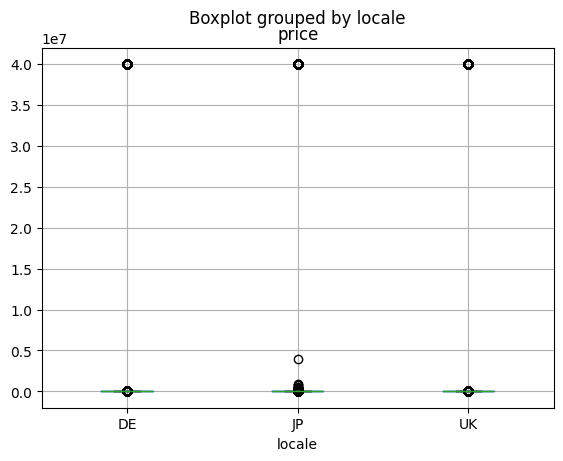

In [8]:
filtered_products.boxplot(column=['price'],by='locale')

In [9]:
filtered_products['price_normalized'] = filtered_products.groupby('locale')['price'].transform(lambda x: (x - x.min()) / (x.max()-x.min()))

In [10]:
text_cols = ['title','author','locale','brand','model','size','color','material','desc']
filtered_products[text_cols] = filtered_products[text_cols].fillna('')

concat_text_template = lambda x: \
'''Product: {title}
Author: {author}
Locale: {locale}
Brand: {brand}
Model: {model}
Size: {size}
Color: {color}
Material: {material}'''.format(**x)

filtered_products = filtered_products.assign(concat_text=filtered_products.apply(concat_text_template, 1))

count    607048.000000
mean         31.162091
std           9.823791
min          10.000000
25%          23.000000
50%          31.000000
75%          38.000000
max         242.000000
Name: concat_text, dtype: float64


<Axes: >

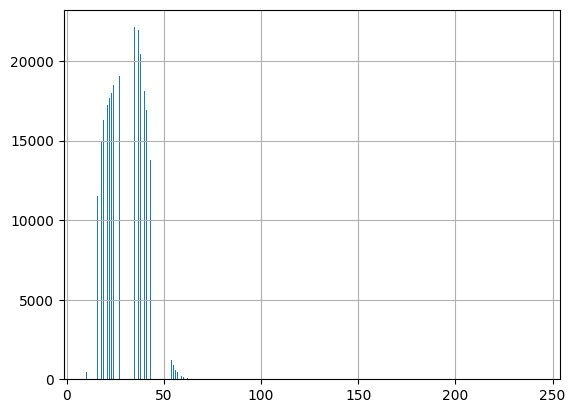

In [11]:
check_concat_text = filtered_products['concat_text'].apply(lambda n: len(n.split()))
print(check_concat_text.describe())
filtered_products['concat_text'].apply(lambda n: len(n.split())).hist(bins=1000)

In [12]:
filtered_products['desc'].head()

1                                                     
2    🔐【 Anti-Friction & Customer First】Each box of ...
3          Air Cushion Technology for shock absorption
4    After-sale Service- If you have any product qu...
5        Colour - Yellow, CE Approved, Made in Britain
Name: desc, dtype: object

In [13]:
text_embed_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device=device)
text_embed_model.max_seq_length = 256
# embeddings = text_embed_model.encode(products['concat_text'][:10].tolist())
# print(embeddings)

In [14]:
filtered_products_features = np.column_stack((filtered_products['price_normalized'].tolist(),
                                    text_embed_model.encode(filtered_products['concat_text'].tolist(),batch_size=512,device=device,show_progress_bar=True),
                                    text_embed_model.encode(filtered_products['desc'].tolist(),batch_size=512,device=device,show_progress_bar=True),))
filtered_products_features.shape

Batches: 100%|██████████| 1186/1186 [13:15<00:00,  1.49it/s]


(607048, 769)

In [15]:
pickle.dump(filtered_products_features, open('./SRGNN_dataset/filtered_products_with_features.txt', 'wb'))